**Importy**

In [6]:
# essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score
import seaborn as sns
import pathlib
import PIL
import PIL.Image
import os
import math

# tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

# others
import splitfolders as sf
import warnings
warnings.filterwarnings("ignore")

**Podział katalogów na części** train,test,validation. Zapisuje zbiór w nowym katalogu.

In [7]:
fixed_value = 100
val_test_batch_size = fixed_value*4

In [8]:
# Niezbalansowany, wykorzystać z wagami
'''
sf.ratio("COVID-19_Radiography_Dataset", 
         output="COVID-19_Radiography_Dataset_split_ratio", 
         ratio=(.8, .1, .1),
         seed=1, 
         group_prefix=None)
''';

In [9]:
# Zbalansowany, wykorzystać bez wag lub z wagami 1
'''
sf.fixed("COVID-19_Radiography_Dataset", 
                   output="COVID-19_Radiography_Dataset_split_fixed", 
                   seed=1, 
                   oversample=True, 
                   fixed=(fixed_value, fixed_value),
                   group_prefix=None)
''';

**Zbalansowanie i liczebność podzbiorów**

Jeśli powyżej wybrano *sf.ratio* to zbiór jest niezbalansowany. Należy wtedy próbować temu zapobiegać z pomocą nadawania wag klasom. Jeśli wybrano *sf.fixed* to zbiór jest zbalansowany poprzed nadpróbkowanie zbioru treningowego. Zbiory testowy i walidacyjny zawierają jedynie oryginalne próbki w ustalonej *fixed* ilości.

In [10]:
base_dir = "C:\\Users\\matlaczj\\Documents\\PROIN\\Tensorflow\\COVID-19_Radiography_Dataset_split_fixed\\"
train_dir = base_dir + "train"
test_dir = base_dir + "test"
val_dir = base_dir + "val"

train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)
val_dir = pathlib.Path(val_dir)

dlugosci_train = []
dlugosci_test = []
dlugosci_val = []

files = ['*/*.png','COVID/*','Lung_Opacity/*','Normal/*','Viral Pneumonia/*']

for directory in [[train_dir,dlugosci_train],[test_dir,dlugosci_test],[val_dir,dlugosci_val]]:
    for clas in files:
        directory[1].append(len(list(directory[0].glob(clas))))

<BarContainer object of 4 artists>

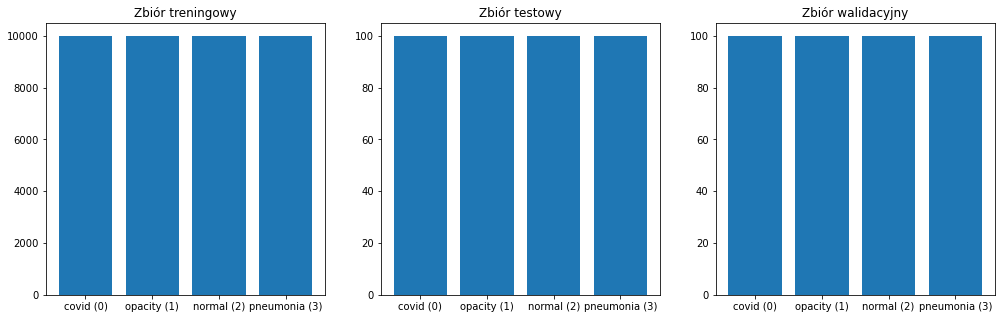

In [11]:
legend = ['covid (0)', 'opacity (1)', 'normal (2)','pneumonia (3)']
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.title('Zbiór treningowy')
plt.bar(legend,dlugosci_train[1:])
plt.subplot(1,3,2)
plt.title('Zbiór testowy')
plt.bar(legend,dlugosci_test[1:])
plt.subplot(1,3,3)
plt.title('Zbiór walidacyjny')
plt.bar(legend,dlugosci_val[1:])

**Obliczenie wag klas**

Obliczone wagi dla poszczególnych klas, tak aby w trakcie uczenia zwrócić większą uwagę modelu na pewne podreprezentowane dane. Oznacza to, że *loss* dla takiej próbki jest większy, czyli model płaci więcej za jej złe sklasyfikowanie. Dzięki temu gradient dla danej próbki będzie większy, więc będzie miał większy wpływ na uśredniony gradient w *batchu*, a więc i na krok *gradient descent*. W przeciwieństwie do *oversamplingu* jest to metoda gorsza, ponieważ efekt jej stosowania przypomina trenowanie na źle wymieszanym zbiorze, gdzie próbki podreprezentowanych klas miałyby występujące przy sobie ilości identycznych kopii w ilości proporcjonalnej do wielkości wagi, a właściwie jej proporcji w stosunku do wag pozostałych klas. Z tego powodu w dalszej części używano zbioru *oversamplowanego*.

In [12]:
def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

In [13]:
ile = np.array(dlugosci_train)
weights = dict(zip([0,1,2,3], ile))
weights = create_class_weight(weights,mu=1)
weights

{0: 1.0, 1: 1.9459101490553132, 2: 1.9459101490553132, 3: 1.9459101490553132}

**Pobranie zbioru**

Zbiór należy wstępnie przetworzyć.
* Jednakowy rozmiar próbek (ze *smart resize*)
* Połączenie 3 kanałów RGB w 1 kanał w skali szarości.
* Zmniejszenie zakresu wartości pikseli do zakresu [0,1].

Najwygodniej było auto-podzielić zbiór na poziomie katalogów w *SO*, a następnie wczytać z nich dane do obiektów typu *Dataset*. Zdecydowano się na znaczne zmniejszenie rozmiaru obrazków, ponieważ nie zauważono znacznej poprawy wyników dla rozmiarów większych.

In [14]:
batch_size = 512
img_height = 64
img_width = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='int', #For sparse_categorical_crossentropy 
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=1,
    interpolation='bilinear',
    smart_resize = True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=val_dir,
    labels='inferred',
    label_mode='int',
    color_mode="grayscale",
    batch_size=val_test_batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=1,
    interpolation='bilinear',
    smart_resize = True
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='int',
    color_mode="grayscale",
    batch_size=val_test_batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=1,
    interpolation='bilinear',
    smart_resize = True
)

class_names = train_ds.class_names
print(class_names)

Found 39968 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


**Oglądanie zbioru**, czyli kilka pierwszych obrazków z jednego z batchy ze zbioru treningowego.

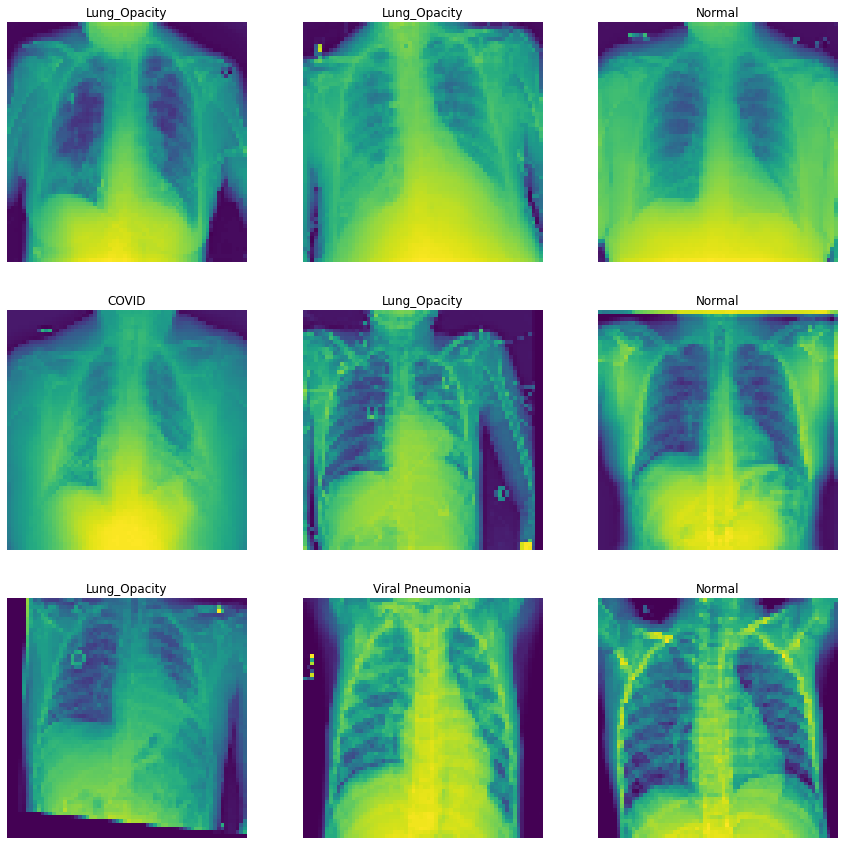

In [10]:
rows = 3
cols = 3
if(rows*cols > batch_size):
    print("Too many pictures for current batch_size")
else:
    plt.figure(figsize=(15, 15))
    for images, labels in train_ds.take(1):
        for i in range(rows*cols):
            ax = plt.subplot(rows, cols, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

**Buforowanie i buforowanie wstępne**, w celu uniknięcia zagładzania GPU. W tym celu modyfikujemy obiekty *BatchDataset*. <br>
https://www.tensorflow.org/guide/data_performance#caching <br>
https://www.tensorflow.org/guide/data_performance#prefetching

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Topologia modelu**

Zastosowano 4 warstwy konwolucyjne, gdzie ilość *kerneli* maleje, a ich wielkość rośnie. Oznacza to, że na początku wykrywamy wiele małych cech, a następnie coraz mniej większych cech, które powstały z cech wyekstraktowanych w poprzednich *layerach*. W ten sposób stopniowo zamieniamy zbiór pikseli na zbiór abstrakcyjnych cech, po których możnaby stwierdzić przynależność do klasy. W międzyczasie stosujemy *dropout*, który świetnie walczy z przetrenowaniem. Im jest większy (*aż do jakiejś rozsądnej wartości*), tym bardziej zbliża *accuracy* walidacyjną do treningowej. 

In [12]:
n_classes = 4
dropout = 0.55

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 1)),
    
  layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(dropout),
    
  layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(dropout),
    
  layers.Conv2D(filters=16, kernel_size=(7,7), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(dropout),
    
  layers.Conv2D(filters=8, kernel_size=(9,9), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(dropout),
    
  layers.Flatten(),
  layers.Dropout(dropout),
  layers.Dense(64, activation='relu'),
  layers.Dropout(dropout),
  layers.Dense(n_classes)
])

**Kompilacja modelu**

Wybrano wielkość kroku standardową w *Adamie*, ponieważ dla większej model trenował się zbyt wolno, a nie widać było też znacznej poprawy wyników. Wielkość zdaje się być odpowiednia, aby model *wyczuł* lokalne minima w *funkcji strat* i był w stanie za nimi podążać oraz by ich nie *przeskakiwał*.

Model składa się z około 96 tys. parametrów, więc na prawdę nie jest to ogromna ilość. Dzięki temu szybciej się trenował. Znaje się, że jest jednak dostatecznie duży, aby *ogarnąć* złożoność problemu.

In [13]:
model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0

**Dopasowanie modelu do danych**

Skorzystano z kilku *Callbacków*.
* Niewdrożone eksprymenty ze zmniejszaniem *LR* po każdej epoce.
* Obliczanie średniego *recall* oraz *precision* po każdej epoce, ponieważ oryginalny zbiór był niezbalansowany.
* Wczesne zatrzymywanie jeśli *accuracy* zbyt długo spada (*patience*) oraz po *f1*.

In [15]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        skalar = 0.99
        old_lr = self.model.optimizer.lr.read_value()
        new_lr = old_lr * skalar
        print("\n>> Reducing Learning Rate from {} to {}\n".format(old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)

In [16]:
class ExtendedHistoryCb(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_recalls = []
        self.val_precisions = []
        self.val_f1s_from_avg = []
        
        self.avg_val_recall = []
        self.avg_val_precision = []
        self.val_f1_from_avg = []
    def on_epoch_end(self, batch, logs={}):
        val_predictions = model.predict(val_ds)
        val_predictions = tf.math.argmax(val_predictions, axis=1).numpy()
        val_labels = np.concatenate([y for x, y in val_ds], axis=0)
        
        val_multiclass_recalls = recall_score(val_labels, val_predictions, average=None)
        val_multiclass_precisions = precision_score(val_labels, val_predictions, average=None)
        
        self.val_recalls.append(val_multiclass_recalls)
        self.val_precisions.append(val_multiclass_precisions)
        
        self.avg_val_recall = sum(val_multiclass_recalls)/4
        self.avg_val_precision = sum(val_multiclass_precisions)/4
        self.val_f1_from_avg = 2*(self.avg_val_precision*self.avg_val_recall)/(self.avg_val_precision+self.avg_val_recall)
        self.val_f1s_from_avg.append(self.val_f1_from_avg)
        
        msg = "Val Recall: "+str(self.avg_val_recall)+" Val Precision: "+str(self.avg_val_precision)+" F1 From Avg: "+str(self.val_f1_from_avg)
        tf.print(msg)
        
extended_history = ExtendedHistoryCb();

In [17]:
class EarlyStopByF1(keras.callbacks.Callback):
    def __init__(self, patience = 0):
        super(keras.callbacks.Callback, self).__init__()
        self.patience = patience
    def on_epoch_end(self, epoch, logs={}):
        f1_history = extended_history.val_f1s_from_avg
        f1 = extended_history.val_f1_from_avg
        if(epoch >= self.patience):
            if f1 < min(f1_history[-self.patience:]):
                tf.print("Epoch %05d: early stopping Threshold" % epoch)
                self.model.stop_training = True

In [18]:
history = model.fit(
    train_ds,
    batch_size=batch_size, 
    epochs=200,
    verbose=1,
    callbacks=[
        #EarlyStopping(monitor='val_loss',patience=4,verbose=1),
        extended_history,
        #EarlyStopByF1(patience=1)
        #LearningRateReducerCb()
        ], 
    validation_data=val_ds,
    shuffle=True#,
    #class_weight=weights,
)

Epoch 1/200
79/79 [==============================] - 16s 143ms/step - loss: 1.3894 - accuracy: 0.2546 - val_loss: 1.3855 - val_accuracy: 0.2475
Val Recall: 0.2475 Val Precision: 0.06234256926952141 F1 From Avg: 0.09959758551307847
Epoch 2/200
79/79 [==============================] - 5s 63ms/step - loss: 1.2813 - accuracy: 0.3622 - val_loss: 1.0761 - val_accuracy: 0.4975
Val Recall: 0.49750000000000005 Val Precision: 0.5135126424079774 F1 From Avg: 0.5053795153134732
Epoch 3/200
79/79 [==============================] - 5s 62ms/step - loss: 1.0516 - accuracy: 0.5132 - val_loss: 0.9244 - val_accuracy: 0.6400
Val Recall: 0.6399999999999999 Val Precision: 0.6416196982276269 F1 From Avg: 0.6408088256345581
Epoch 4/200
79/79 [==============================] - 5s 62ms/step - loss: 0.9374 - accuracy: 0.5867 - val_loss: 0.8369 - val_accuracy: 0.6450
Val Recall: 0.645 Val Precision: 0.6507759141648518 F1 From Avg: 0.6478750840292711
Epoch 5/200
79/79 [==============================] - 5s 62ms/ste

Epoch 37/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3954 - accuracy: 0.8561 - val_loss: 0.3101 - val_accuracy: 0.8775
Val Recall: 0.8775 Val Precision: 0.8789631458296597 F1 From Avg: 0.8782309635095816
Epoch 38/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3943 - accuracy: 0.8584 - val_loss: 0.3161 - val_accuracy: 0.8725
Val Recall: 0.8725 Val Precision: 0.8750879623521134 F1 From Avg: 0.8737920649494403
Epoch 39/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3931 - accuracy: 0.8584 - val_loss: 0.3050 - val_accuracy: 0.8725
Val Recall: 0.8725 Val Precision: 0.8741257558120935 F1 From Avg: 0.8733121212808934
Epoch 40/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3925 - accuracy: 0.8581 - val_loss: 0.3052 - val_accuracy: 0.8825
Val Recall: 0.8825000000000001 Val Precision: 0.8874424917188075 F1 From Avg: 0.8849643450068323
Epoch 41/200
79/79 [==============================] - 5s 62ms/step - loss: 0

Val Recall: 0.895 Val Precision: 0.8977959061498666 F1 From Avg: 0.896395772935194
Epoch 108/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3271 - accuracy: 0.8839 - val_loss: 0.2626 - val_accuracy: 0.8950
Val Recall: 0.895 Val Precision: 0.8960228467873728 F1 From Avg: 0.8955111313216024
Epoch 109/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3245 - accuracy: 0.8854 - val_loss: 0.2784 - val_accuracy: 0.8900
Val Recall: 0.8899999999999999 Val Precision: 0.8960572322414428 F1 From Avg: 0.893018344875835
Epoch 110/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3243 - accuracy: 0.8850 - val_loss: 0.2607 - val_accuracy: 0.9000
Val Recall: 0.9 Val Precision: 0.9012686189347724 F1 From Avg: 0.9006338627283533
Epoch 111/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3348 - accuracy: 0.8808 - val_loss: 0.2714 - val_accuracy: 0.9000
Val Recall: 0.9 Val Precision: 0.904565870687366 F1 From Avg: 0.902277159113656

Epoch 143/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3187 - accuracy: 0.8878 - val_loss: 0.2625 - val_accuracy: 0.9000
Val Recall: 0.8999999999999999 Val Precision: 0.9022535403050109 F1 From Avg: 0.9011253612375574
Epoch 144/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3091 - accuracy: 0.8897 - val_loss: 0.2513 - val_accuracy: 0.9000
Val Recall: 0.8999999999999999 Val Precision: 0.9041265763157051 F1 From Avg: 0.9020585688015965
Epoch 145/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3082 - accuracy: 0.8906 - val_loss: 0.2771 - val_accuracy: 0.8950
Val Recall: 0.895 Val Precision: 0.8982522980164489 F1 From Avg: 0.8966231997739199
Epoch 146/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3053 - accuracy: 0.8926 - val_loss: 0.2668 - val_accuracy: 0.9000
Val Recall: 0.8999999999999999 Val Precision: 0.9027843655187218 F1 From Avg: 0.9013900325600662
Epoch 147/200
79/79 [============================

Epoch 178/200
79/79 [==============================] - 5s 62ms/step - loss: 0.2964 - accuracy: 0.8949 - val_loss: 0.2631 - val_accuracy: 0.8975
Val Recall: 0.8975 Val Precision: 0.9027968667437722 F1 From Avg: 0.9001406411022278
Epoch 179/200
79/79 [==============================] - 5s 62ms/step - loss: 0.2954 - accuracy: 0.8942 - val_loss: 0.2467 - val_accuracy: 0.8975
Val Recall: 0.8975 Val Precision: 0.9004568293672193 F1 From Avg: 0.8989759833571829
Epoch 180/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3041 - accuracy: 0.8918 - val_loss: 0.2591 - val_accuracy: 0.9025
Val Recall: 0.9025 Val Precision: 0.9056188736670884 F1 From Avg: 0.9040567469183254
Epoch 181/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3051 - accuracy: 0.8921 - val_loss: 0.2454 - val_accuracy: 0.9000
Val Recall: 0.9 Val Precision: 0.9024768960755811 F1 From Avg: 0.9012367462089952
Epoch 182/200
79/79 [==============================] - 5s 62ms/step - loss: 0.3005 - ac

**Wizualizacja procesu trenowania**, na wykresach *loss* oraz *accuracy*.

In [19]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


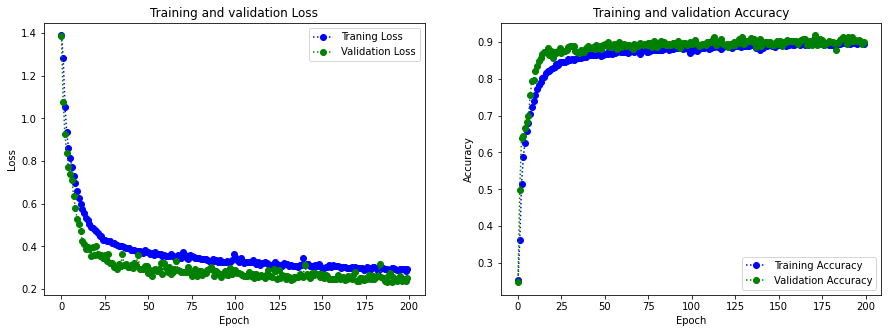

In [20]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Training and validation Loss')
plt.plot(loss,'bo:',label="Traning Loss")
plt.plot(val_loss,'go:',label="Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and validation Accuracy')
plt.plot(accuracy,'bo:',label="Training Accuracy")
plt.plot(val_accuracy,'go:',label="Validation Accuracy")
plt.legend()

,Recall(0),Recall(1),Recall(2),Recall(3),Precision(0),Precision(1),Precision(2),Precision(3)
0,0.00,0.00,0.99,0.00,0.000000,0.000000,0.249370,0.000000
1,0.02,0.23,0.85,0.89,0.333333,0.511111,0.345528,0.864078
2,0.62,0.37,0.62,0.95,0.504065,0.627119,0.579439,0.855856
3,0.65,0.48,0.46,0.99,0.485075,0.623377,0.676471,0.818182
4,0.64,0.45,0.59,0.98,0.516129,0.681818,0.627660,0.844828
5,0.68,0.50,0.56,0.99,0.539683,0.704225,0.651163,0.846154
6,0.85,0.41,0.53,1.00,0.531250,0.891304,0.679487,0.862069
7,0.86,0.54,0.62,1.00,0.609929,0.870968,0.729412,0.892857
8,0.86,0.62,0.70,1.00,0.699187,0.873239,0.744681,0.892857
9,0.89,0.64,0.66,1.00,0.741667,0.831169,0.750000,0.869565


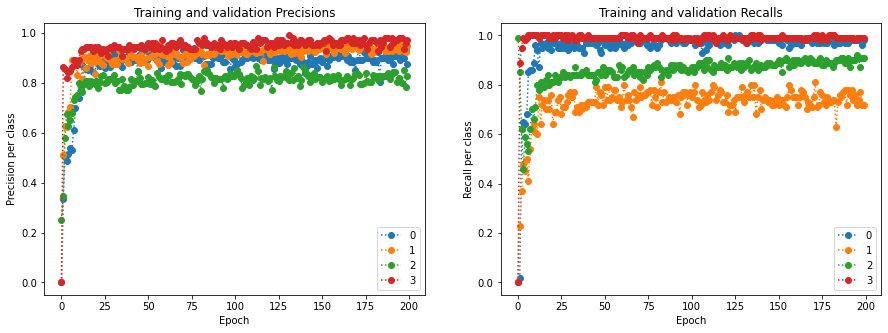

In [21]:
val_recall = extended_history.val_recalls
val_precision = extended_history.val_precisions

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.xlabel("Epoch")
plt.ylabel("Recall per class")
plt.title('Training and validation Recalls')
plt.plot(val_recall,'o:',label="Validation Recall")
plt.legend([0,1,2,3])

plt.subplot(1,2,1)
plt.xlabel("Epoch")
plt.ylabel("Precision per class")
plt.title('Training and validation Precisions')
plt.plot(val_precision,'o:',label="Validation Precision")
plt.legend([0,1,2,3])

pd.DataFrame(np.concatenate((val_recall, val_precision), axis=1), 
             columns=['Recall(0)','Recall(1)','Recall(2)','Recall(3)','Precision(0)','Precision(1)','Precision(2)','Precision(3)']).head(10)

**Zapisanie modelu**, topologia i wagi.

In [33]:
#model.save('model_3')

INFO:tensorflow:Assets written to: model_3\assets


**Ewentualne wczytanie modelu**

In [2]:
model = keras.models.load_model('model_3')

**Macierz pomyłek** dla zbioru walidacyjnego.

In [3]:
def plotrp(recalls,precisions):
    '''Helper method. Only for very specific usecase.'''
    legend = ['covid (0)', 'opacity (1)', 'normal (2)','pneumonia (3)']
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.title('Recall')
    plt.bar(legend,recalls)
    plt.subplot(1,2,2)
    plt.title('Precision')
    plt.bar(legend,precisions)

In [4]:
def plotconf(ds):
    '''Helper method. Only for very specific usecase.'''
    predictions = model.predict(ds)
    predicted_labels = tf.math.argmax(predictions, axis=1).numpy()
    labels = np.concatenate([y for x, y in ds], axis=0)
    confusion = tf.math.confusion_matrix(labels, predicted_labels, num_classes=4)
    sns.heatmap(confusion, annot = confusion)
    return (predicted_labels,labels)

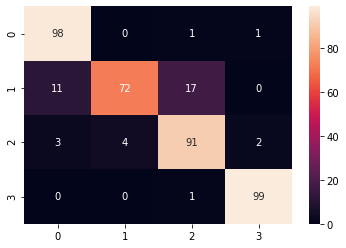

In [15]:
val_predicted_labels,val_labels = plotconf(val_ds)

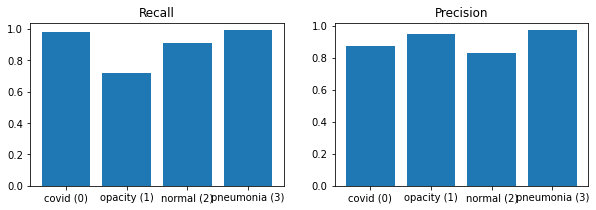

In [16]:
val_recalls = recall_score(val_labels, val_predicted_labels, average=None)
val_precisions = precision_score(val_labels, val_predicted_labels, average=None)
plotrp(val_recalls,val_precisions)

**Testowanie**,  na zbiorze testowym, które nigdy nie widział model, ani nie był używany do dopasowania modelu. Macierz pomyłek.

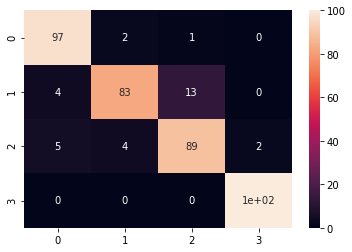

In [17]:
test_predicted_labels,test_labels = plotconf(test_ds)

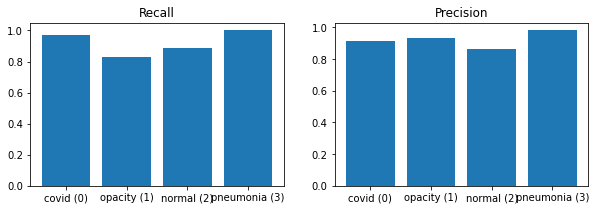

In [18]:
test_recalls = recall_score(test_labels, test_predicted_labels, average=None)
test_precisions = precision_score(test_labels, test_predicted_labels, average=None)
plotrp(test_recalls,test_precisions)

**Oglądanie decyzji modelu**, na całym zbiorze testowym (400 próbek, po 100 na klasę).

In [24]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    np.max(tf.nn.softmax(test_predictions[0])*100),
                                    class_names[true_label]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    n_classes = 4
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(n_classes))
    plt.yticks([])
    thisplot = plt.bar(range(n_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

NameError: name 'test_predictions' is not defined

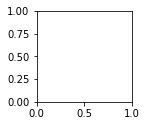

In [25]:
# Zakłada rozmiar batcha = rozmiar całego zbioru, czyli 1 iteracja for
for test_images, test_labels in test_ds:
    num_rows = 100
    num_cols = 4
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows)) 
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, test_predictions[i], test_labels, test_images)    
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, test_predictions[i], test_labels)       
    plt.tight_layout()
    plt.show()

**TODO**
* Zwiększyć zbiór o rotacje, odwrócenia itp.
* Early stop zależnie od recall/precision (lub razem od f1)
* Dodać wykres f1 dla klas